<a href="https://colab.research.google.com/github/CompOmics/lsabd-machine-learning-tutorials/blob/main/notebooks/3-overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overfitting and regularization

This notebook demonstrates how machine learning models can achieve 100% training accuracy but perform poorly on test data due to overfitting. We'll visualize this phenomenon using a synthetic non-linear dataset (half-moons) and a simple decision tree. Then, we'll explore how regularization techniques like limiting tree depth can help mitigate overfitting.

## What is overfitting?

Overfitting occurs when a model learns the training data too well, capturing noise and outliers rather than just the underlying pattern. This results in:
- Excellent performance on training data
- Poor performance on new, unseen data (test data)

In biological datasets, especially -omics data (e.g., transcriptomics, proteomics), overfitting is a common challenge due to the high dimensionality and complexity of the data. We often get a low number of samples (10 to 100) compared to a very high number of features (thousands to tens of thousands). This imbalance makes it easy for models to memorize the training data instead of learning generalizable patterns. This is often called the "curse of dimensionality."

Decision trees are particularly prone to overfitting because they can create very complex decision boundaries that perfectly separate the training data. Nevertheless, overfitting can occur with virtually any machine learning algorithm if not properly regularized.

First, let's import the necessary libraries:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from sklearn.datasets import make_moons, make_classification, make_regression
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Set the style for our visualizations
sns.set_style("whitegrid")
sns.set_palette("colorblind")

# Set random seed for reproducibility
np.random.seed(42)

## Visualizing overfitting with a decision tree model

### Data generation

We'll generate a synthetic non-linear dataset using scikit-learn's [`make_moons`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function. This creates two interleaving half-moons, which is a classic example of data that requires non-linear decision boundaries.

To make overfitting more pronounced, we'll also add some noise and outliers by flipping the labels of a few random points.

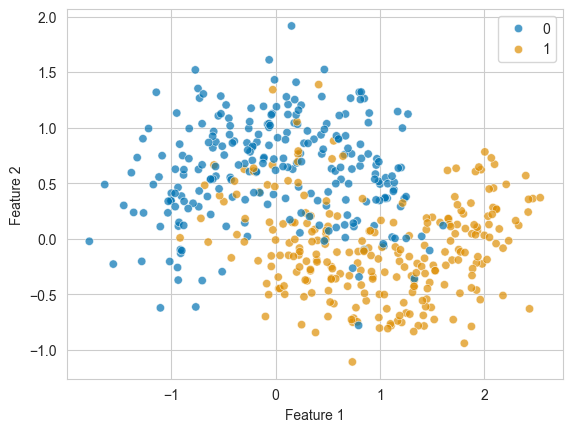

In [2]:
# Generate a non-linear dataset (half-moons)
features, target = make_moons(n_samples=500, noise=0.3, random_state=1)

# Add some noise/outliers to make overfitting more pronounced
# Add 20 random outliers
n_outliers = 20
outlier_indices = np.random.choice(len(features), n_outliers, replace=False)

# Flip the labels for these outliers
target[outlier_indices] = 1 - target[outlier_indices]

# Visualize the dataset
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=target, alpha=0.7)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

*Question: How many features does this dataset have?*

*Answer: The dataset has 2 features, each plotted on one axis.*

### Data splitting

We'll split our data into training (70%) and testing (30%) sets. The training set will be used to train our models, while the testing set will be used to evaluate their performance on unseen data.

In [3]:
# Split data into training and testing sets
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.3, random_state=42)

print(f"Training set size: {train_features.shape[0]} samples")
print(f"Testing set size: {test_features.shape[0]} samples")

Training set size: 350 samples
Testing set size: 150 samples


### Training an unrestricted decision tree

First, let's train a decision tree with default parameters. By default, scikit-learn's [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/tree.html#classification) will grow a tree until all leaves are pure (contain samples of only one class) or until all leaves contain less than `min_samples_split` samples.

This allows the tree to potentially grow very deep and create a complex decision boundary that perfectly fits the training data, including noise and outliers.

In [4]:
# Create a decision tree classifier with default parameters
# This allows tree to grow fully and potentially overfit
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(train_features, train_target)

# Make predictions to evaluate performance
train_predictions = classifier.predict(train_features)
test_predictions = classifier.predict(test_features)

# Calculate accuracies
train_accuracy = accuracy_score(train_target, train_predictions)
test_accuracy = accuracy_score(test_target, test_predictions)

print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Testing accuracy: {test_accuracy:.4f}")

Training accuracy: 1.0000
Testing accuracy: 0.7533


*Question: Do you already observe something interesting about the accuracies?*

*Answer: The training accuracy is 100%, indicating perfect fit to the training data, while the test accuracy is significantly lower, suggesting overfitting.*

### Training a regularized decision tree

Now, let's train a regularized decision tree by limiting its maximum depth to 3. This prevents the tree from creating an overly complex decision boundary and forces it to focus on the most important patterns in the data.

In [5]:
# Create a regularized tree with limited depth for comparison
reg_classifier = DecisionTreeClassifier(max_depth=3, random_state=42)
reg_classifier.fit(train_features, train_target)

reg_train_predictions = reg_classifier.predict(train_features)
reg_test_predictions = reg_classifier.predict(test_features)

reg_train_accuracy = accuracy_score(train_target, reg_train_predictions)
reg_test_accuracy = accuracy_score(test_target, reg_test_predictions)

print("Regularized tree:")
print(f"Training accuracy: {reg_train_accuracy:.4f}")
print(f"Testing accuracy: {reg_test_accuracy:.4f}")

Regularized tree:
Training accuracy: 0.9171
Testing accuracy: 0.7800


*Question: How do the accuracies compare to the unrestricted tree? What does that tell you?*

*Answer: The training accuracy is lower than that of the unrestricted tree, but the test accuracy is higher. This indicates that the regularized tree generalizes better to unseen data, reducing overfitting.*

### Visualizing decision boundaries

Let's visualize the decision boundaries of our models using the `mlxtend` library. This will help us see how the unrestricted tree creates a complex boundary that perfectly fits the training data, while the regularized tree creates a simpler boundary that generalizes better to unseen data.

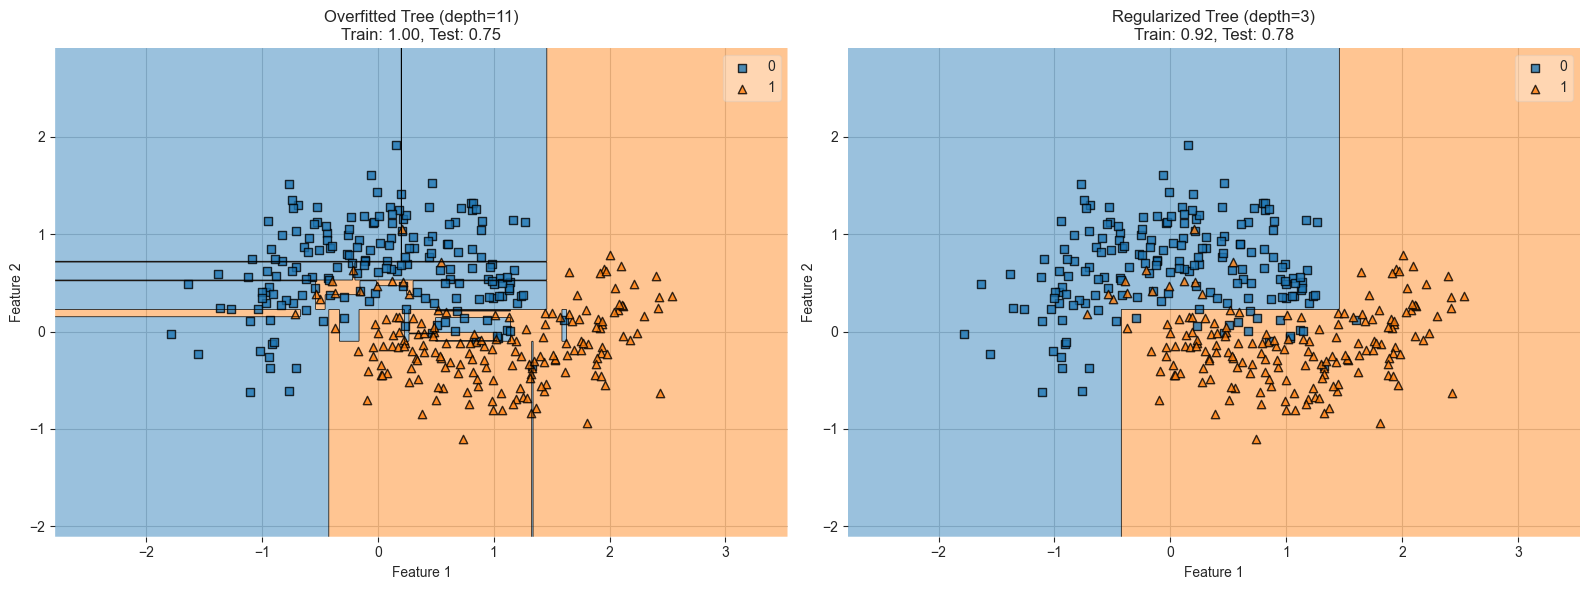

In [6]:
# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot decision boundary for overfitted tree
plot_decision_regions(train_features, train_target, clf=classifier, ax=ax1)
ax1.set_title(
    f"Overfitted Tree (depth={classifier.get_depth()})\n"
    f"Train: {train_accuracy:.2f}, Test: {test_accuracy:.2f}",
)

# Plot decision boundary for regularized tree
plot_decision_regions(train_features, train_target, clf=reg_classifier, ax=ax2)
ax2.set_title(
    f"Regularized Tree (depth={reg_classifier.get_depth()})\n"
    f"Train: {reg_train_accuracy:.2f}, Test: {reg_test_accuracy:.2f}"
)

for ax in (ax1, ax2):
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")

fig.tight_layout()
plt.show()

Investigate the plots to see how the decision boundaries differ between the unrestricted and regularized trees. Notice how the unrestricted tree's boundary is highly irregular, while the regularized tree's boundary better captures the overall structure of the data.

*Question: Where did the unregularized tree overfit the data? What do you notice about the irregularly fitted regions?*

*Answer: The unregularized tree overfit the data in regions where there are outliers or noisy data points, creating complex boundaries that isolate individual points. These irregularly fitted regions often correspond to areas with fewer data points, indicating that the model is capturing noise rather than the underlying pattern.*

### The effect of tree depth on overfitting

Let's explore how the maximum depth of the tree affects its performance on training and testing data. We'll train multiple trees with different maximum depths and plot their accuracies.

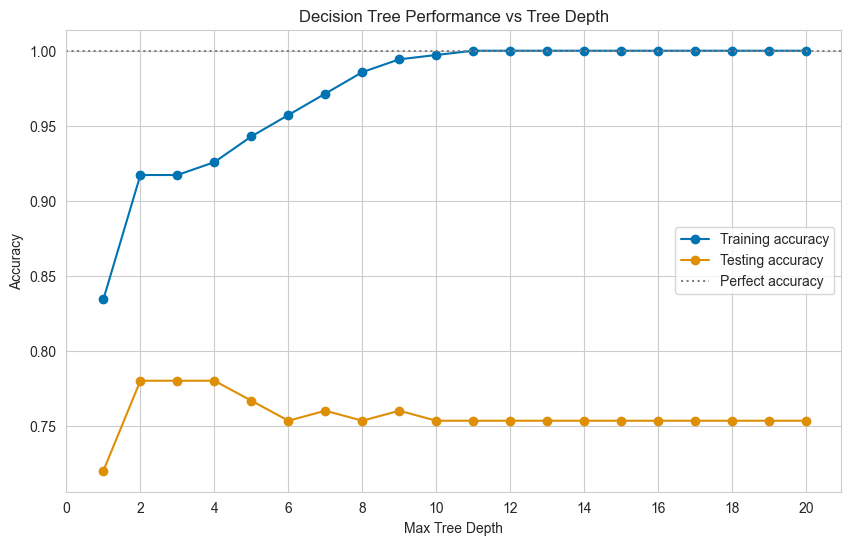

In [7]:
# Parameter values to try
max_depths = range(1, 21)
train_scores = []
test_scores = []

for depth in max_depths:
    # Train tree with specific depth
    classifier = DecisionTreeClassifier(max_depth=depth, random_state=42)
    classifier.fit(train_features, train_target)

    # Record accuracies
    train_scores.append(accuracy_score(train_target, classifier.predict(train_features)))
    test_scores.append(accuracy_score(test_target, classifier.predict(test_features)))

# Plot accuracies vs tree depth
c1, c2 = sns.color_palette("colorblind", 2)
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_scores, "o-", color=c1, label="Training accuracy")
plt.plot(max_depths, test_scores, "o-", color=c2, label="Testing accuracy")
plt.axhline(y=1.0, color="grey", linestyle=":", label="Perfect accuracy")
plt.xticks(range(0, 21, 2))
plt.xlabel("Max Tree Depth")
plt.ylabel("Accuracy")
plt.title("Decision Tree Performance vs Tree Depth")
plt.legend()
plt.show()

This resulting figure is a form of a "learning curve," showing how model complexity (in this case, tree depth) impacts performance. As the tree depth increases, the training accuracy approaches 100%, but the test accuracy may decrease after a certain point due to overfitting.

*Question: What is the ideal value of max depth for this dataset?*

*Answer: The ideal value of max depth for this dataset appears to be around 2 to 3. At this range, the testing accuracy is relatively high without a significant drop from the training accuracy, indicating that the model is generalizing well without overfitting.*

## Regularization for linear models

Linear models, such as linear regression and logistic regression, can also suffer from overfitting. There, we do not limit tree depth but instead apply regularization techniques like Lasso (L1) and Ridge (L2) regularization. These techniques add a penalty term to the loss function that discourages overly complex models by penalizing large weights.

### Regularizing a logistic regression model

To regularize a [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model in scikit-learn, you can set the `penalty` parameter to `'l1'` for Lasso or `'l2'` for Ridge, and adjust the `C` parameter (inverse of regularization strength).

First, we generate a synthetic classification dataset:

In [243]:
# Generate a classification dataset with more features and more noise
features, target = make_classification(
    n_samples=300,
    n_features=200,
    n_informative=50,
    flip_y=0.2,
    shift=0.1,
    random_state=42,
)

# Split the dataset into training and testing sets
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.3, random_state=42)

Now we can fit both an unregularized and a regularized linear regression model to this dataset and compare their performances.

In [244]:
# Logistic regression without regularization
log_reg = LogisticRegression(penalty=None)
log_reg.fit(train_features, train_target)

# Predictions and accuracy
train_pred = log_reg.predict(train_features)
test_pred = log_reg.predict(test_features)

print("Logistic Regression without regularization")
print(f"Training accuracy: {accuracy_score(train_target, train_pred):.4f}")
print(f"Testing accuracy: {accuracy_score(test_target, test_pred):.4f}")
print()

# Logistic regression with L2 regularization
log_reg_reg = LogisticRegression(penalty='l2', C=0.001, max_iter=1000)
log_reg_reg.fit(train_features, train_target)
# Predictions and accuracy
train_pred_reg = log_reg_reg.predict(train_features)
test_pred_reg = log_reg_reg.predict(test_features)
print("Logistic Regression with L2 regularization")
print(f"Training accuracy: {accuracy_score(train_target, train_pred_reg):.4f}")
print(f"Testing accuracy: {accuracy_score(test_target, test_pred_reg):.4f}")

Logistic Regression without regularization
Training accuracy: 1.0000
Testing accuracy: 0.7000

Logistic Regression with L2 regularization
Training accuracy: 0.7952
Testing accuracy: 0.7778


*Question: What difference do you see between the regularized and unregularized logistic regression models?*

*Answer: The model without regularization perfectly fits the training data but performs poorly on the test data, indicating overfitting. In contrast, the regularized model has lower training accuracy but better test accuracy, demonstrating improved generalization.*

Let's compare the performance of logistic regression models with varying levels of regularization. This can be tuned with the `C` parameter in `LogisticRegression`, where smaller values specify stronger regularization.

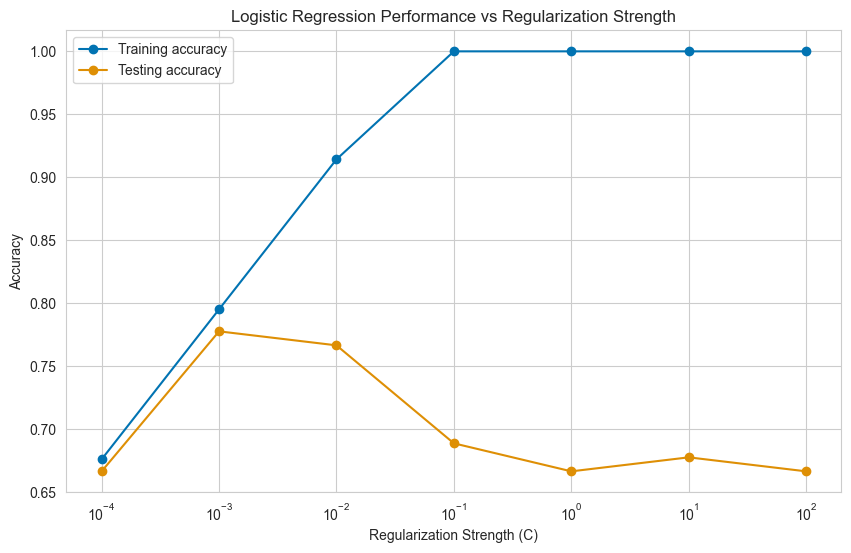

In [245]:
# Learning curves for regularization levels:
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
train_accuracies = []
test_accuracies = []

for C in c_values:
    log_reg = LogisticRegression(penalty='l2', C=C, max_iter=1000)
    log_reg.fit(train_features, train_target)
    train_accuracies.append(accuracy_score(train_target, log_reg.predict(train_features)))
    test_accuracies.append(accuracy_score(test_target, log_reg.predict(test_features)))

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(c_values, train_accuracies, "o-", label="Training accuracy")
plt.plot(c_values, test_accuracies, "o-", label="Testing accuracy")
plt.xscale("log")
plt.xlabel("Regularization Strength (C)")
plt.ylabel("Accuracy")
plt.title("Logistic Regression Performance vs Regularization Strength")
plt.legend()
plt.show()


*Question: What value of C would you choose to in this case?*

*Answer: For this dataset, a C value of 0.001 (or 1e-3) provides a good balance between training and test accuracy, indicating effective regularization without underfitting.*

### Regularizing a linear regression model

To regularize a [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) model, you can use the [`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) classes. For these models, the regularization strength is controlled by the `alpha` parameter, in the range of [0, ∞), where higher values specify stronger regularization (opposite of `C` in logistic regression).

Let's create a synthetic regression dataset that is prone to overfitting by having a small number of samples, a large number of features, and a high noise level:

In [246]:
features, targets = make_regression(
    n_samples=80,         # Small sample size
    n_features=100,       # Many features
    n_informative=3,      # Only some truly useful features
    noise=80,             # High noise level
    random_state=42
)
train_features, test_features, train_target, test_target = train_test_split(features, targets, test_size=0.3, random_state=42)

And train Ridge regression models with varying levels of regularization:

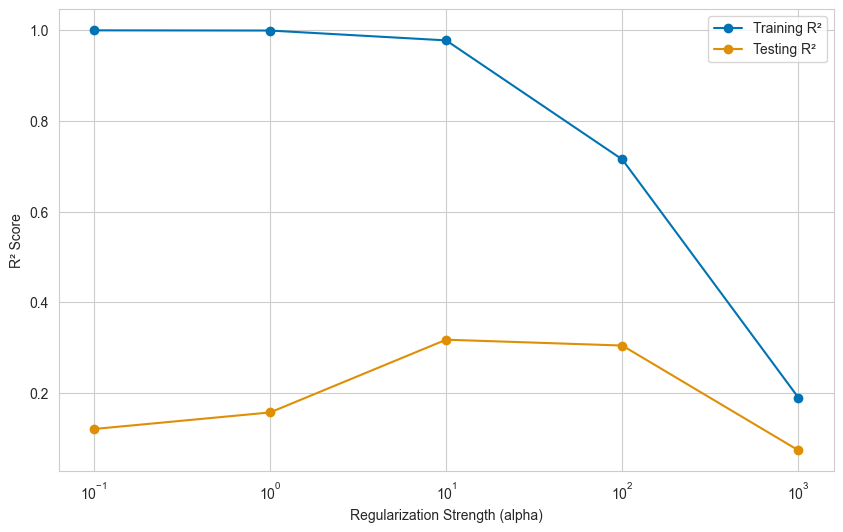

In [247]:
# Learning curves for regularization levels:
alpha_values = [0.1, 1, 10, 100, 1000]
train_r2_scores = []
test_r2_scores = []
for alpha in alpha_values:
    ridge_reg = Ridge(alpha=alpha)
    ridge_reg.fit(train_features, train_target)
    train_r2_scores.append(ridge_reg.score(train_features, train_target))
    test_r2_scores.append(ridge_reg.score(test_features, test_target))

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, train_r2_scores, label="Training R²", marker="o")
plt.plot(alpha_values, test_r2_scores, label="Testing R²", marker="o")
plt.xscale("log")
plt.xlabel("Regularization Strength (alpha)")
plt.ylabel("R² Score")
plt.legend()
plt.show()

*Question: What is the best value of alpha for this dataset?*

*Answer: The best alpha seems to be around 100. At this level of regularization, the model achieves a good balance between training and test R² scores, indicating effective generalization without overfitting.*

*Question: What happens towards the left of the plot (low alpha values) and towards the right of the plot (high alpha values)? In other words, where is the model overfitting, and where is it underfitting?*

*Answer: Towards the left of the plot (low alpha values), the model is overfitting, as indicated by the high training R² score and low test R² score. This means the model is capturing noise in the training data. Towards the right of the plot (high alpha values), the model is underfitting, as both training and test R² scores are lower, indicating that the model is too simple to capture the underlying patterns in the data.*

## Summarized

- Overfitting occurs when a model learns the training data too well, capturing noise and outliers, leading to poor generalization on unseen data.
- Decision trees are particularly prone to overfitting, but regularization techniques like limiting tree depth can help mitigate this.
- Linear models can also overfit, but regularization techniques like Lasso (L1) and Ridge (L2) can help control model complexity.
